In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import bisect
import sklearn
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

In [2]:
class TF:
    
    def __init__(self, vs_dir, tf_dir, resample=True):
        self.vs_dir = vs_dir
        self.tf_dir = tf_dir
        self.max_depth = 500 # 1575
        self.step = 1  # avoid too many frequencies, using 1 for all freqs.
        self.init_freq = np.linspace(0, 500, 8192)
        self.vs = {}
        self.init_tf = {}
        self.load_data()
        self.read_vs()
        self.f_lim = 20
        if resample:
            self.resample_tf(self.f_lim)
        else:
            self.freq = self.init_freq
            self.tf = {k: v for (k, v) in self.init_tf}
        
        
    def load_data(self):
        file_vs = os.listdir(self.vs_dir)
        file_tf = os.listdir(self.tf_dir)
        site_vs = [x.split('.')[0] for x in file_vs]
        site_tf = [x.split('.')[0] for x in file_tf]
        self.sites = list(set(site_vs) & set(site_tf))
        print(f'There are {len(site_vs)} sites of profiles, '
              f'{len(site_tf)} sites of TTFs, '
              f'{len(self.sites)} sites in commnn.')
        self.file_vs = [Path(self.vs_dir, x + '.dat') for x in self.sites]
        self.file_tf = [Path(self.tf_dir, x + '.amp') for x in self.sites]
    
    def build_vs(self, data):
        vs_out = np.zeros((self.max_depth, ))
        n = len(data)
        depth = data[:, 0]
        for i in range(len(vs_out)):
            idx = bisect.bisect_left(depth, i)
            idx -= (idx == n)
            vs_out[i] = data[idx, 1]
        return vs_out

    def read_vs(self):
        # depth + vs
        max_dp = 0
        print(f'Site with larger depth than max_depth ({self.max_depth}): '
                  f'showing last two layers')
        for i, site in enumerate(self.sites):
            data = np.genfromtxt(self.file_vs[i], skip_header=2, delimiter= ',',
                             usecols=[2, 4], filling_values=self.max_depth)
            self.vs[site] = self.build_vs(data).astype('float32')
            self.init_tf[site] = np.genfromtxt(self.file_tf[i], usecols=[1]).astype('float32')      
            # if data[-2, 0] > self.max_depth:
            #     print(data[-2:, :])
            max_dp = max(max_dp, data[-2, 0])
        print(max_dp)
        
    def resample_tf(self, f_lim, step=1):
        """
        Leave freq < f_lim only, every step if necessary
        """
        idx = np.argwhere(self.init_freq < f_lim)
        self.freq = self.init_freq[idx][::step]
        self.tf = {}
        for i, site in enumerate(self.sites):
            self.tf[site] = self.init_tf[site][idx][::step].squeeze()
    
        
    

In [3]:
ttf = TF('sitedat', 'TF')

There are 664 sites of profiles, 643 sites of TTFs, 643 sites in commnn.
Site with larger depth than max_depth (500): showing last two layers
1575.0


In [4]:
vs_data = np.vstack(list(ttf.vs.values()))
tf_data = np.vstack(list(ttf.tf.values()))
print(f'Input dimension = {vs_data.shape}, output dimension = {tf_data.shape}')
X_train, X_test, y_train, y_test = train_test_split(vs_data, tf_data, test_size=0.2)
print(f'Training dataset dimension is: {X_train.shape}')

Input dimension = (643, 500), output dimension = (643, 328)
Training dataset dimension is: (514, 500)


In [10]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        #f_act = nn.LeakyReLU(0.2, True)  
        f_act = nn.ReLU(True)
        self.ann = nn.Sequential(
            #nn.BatchNorm1d(in_dim),
            nn.Linear(in_dim, 1024),
            nn.BatchNorm1d(1024),
            f_act,
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            f_act,
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            f_act,
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            f_act,
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            f_act,
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            f_act,
            nn.Linear(128, 128),         
            nn.BatchNorm1d(128),
            f_act,
            #nn.Sigmoid(),
            nn.Linear(128, len(ttf.freq))
        )

    def forward(self, x):
        out = self.ann(x)
        return out

num_epoches = 800
learning_rate = 0.001

model = Net(X_train.shape[-1], y_train.shape[-1]) 

# he initialization
# https://www.jianshu.com/p/902bb29209ed
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')
        
criterion = nn.MSELoss()

# L2-normalization
# https://blog.csdn.net/ys1305/article/details/97959511
weight_p, bias_p = [],[]
for name, p in model.named_parameters():
    if 'bias' in name:
        bias_p += [p]
    else:
        weight_p += [p]

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam([{'params': weight_p, 'weight_decay': 1e-5},
                       {'params': bias_p, 'weight_decay': 0}],
                       lr=learning_rate)

In [11]:
data_in = torch.from_numpy(X_train).float()
data_out = torch.from_numpy(y_train).float()
for epoch in range(num_epoches):   
    out = model(data_in)
    loss = criterion(out, data_out)
    if (epoch+1) % 50 == 0:
        print('epoch {}'.format(epoch+1))
        print('*'*10)
        print(f'Epoch[{epoch + 1}/{num_epoches}], loss: {loss:.6f}')

    # 向后传播
    optimizer.zero_grad()  # important
    loss.backward()
    optimizer.step()

epoch 50
**********
Epoch[50/800], loss: 62.353794
epoch 100
**********
Epoch[100/800], loss: 51.294304
epoch 150
**********
Epoch[150/800], loss: 44.756664
epoch 200
**********
Epoch[200/800], loss: 38.594074
epoch 250
**********
Epoch[250/800], loss: 33.236809
epoch 300
**********
Epoch[300/800], loss: 28.311426
epoch 350
**********
Epoch[350/800], loss: 24.134130
epoch 400
**********
Epoch[400/800], loss: 20.746302
epoch 450
**********
Epoch[450/800], loss: 17.824305
epoch 500
**********
Epoch[500/800], loss: 15.221539
epoch 550
**********
Epoch[550/800], loss: 28.622046
epoch 600
**********
Epoch[600/800], loss: 12.906721
epoch 650
**********
Epoch[650/800], loss: 10.927444
epoch 700
**********
Epoch[700/800], loss: 9.468149
epoch 750
**********
Epoch[750/800], loss: 8.369500
epoch 800
**********
Epoch[800/800], loss: 7.380500


In [12]:
model.eval()
train = model(torch.Tensor(X_train))
train = train.data.numpy()
predict = model(torch.Tensor(X_test))
predict = predict.data.numpy()
loss = criterion(torch.from_numpy(predict), torch.from_numpy(y_test))
print(f'Prediction loss: {loss}')

Prediction loss: 65.20767974853516


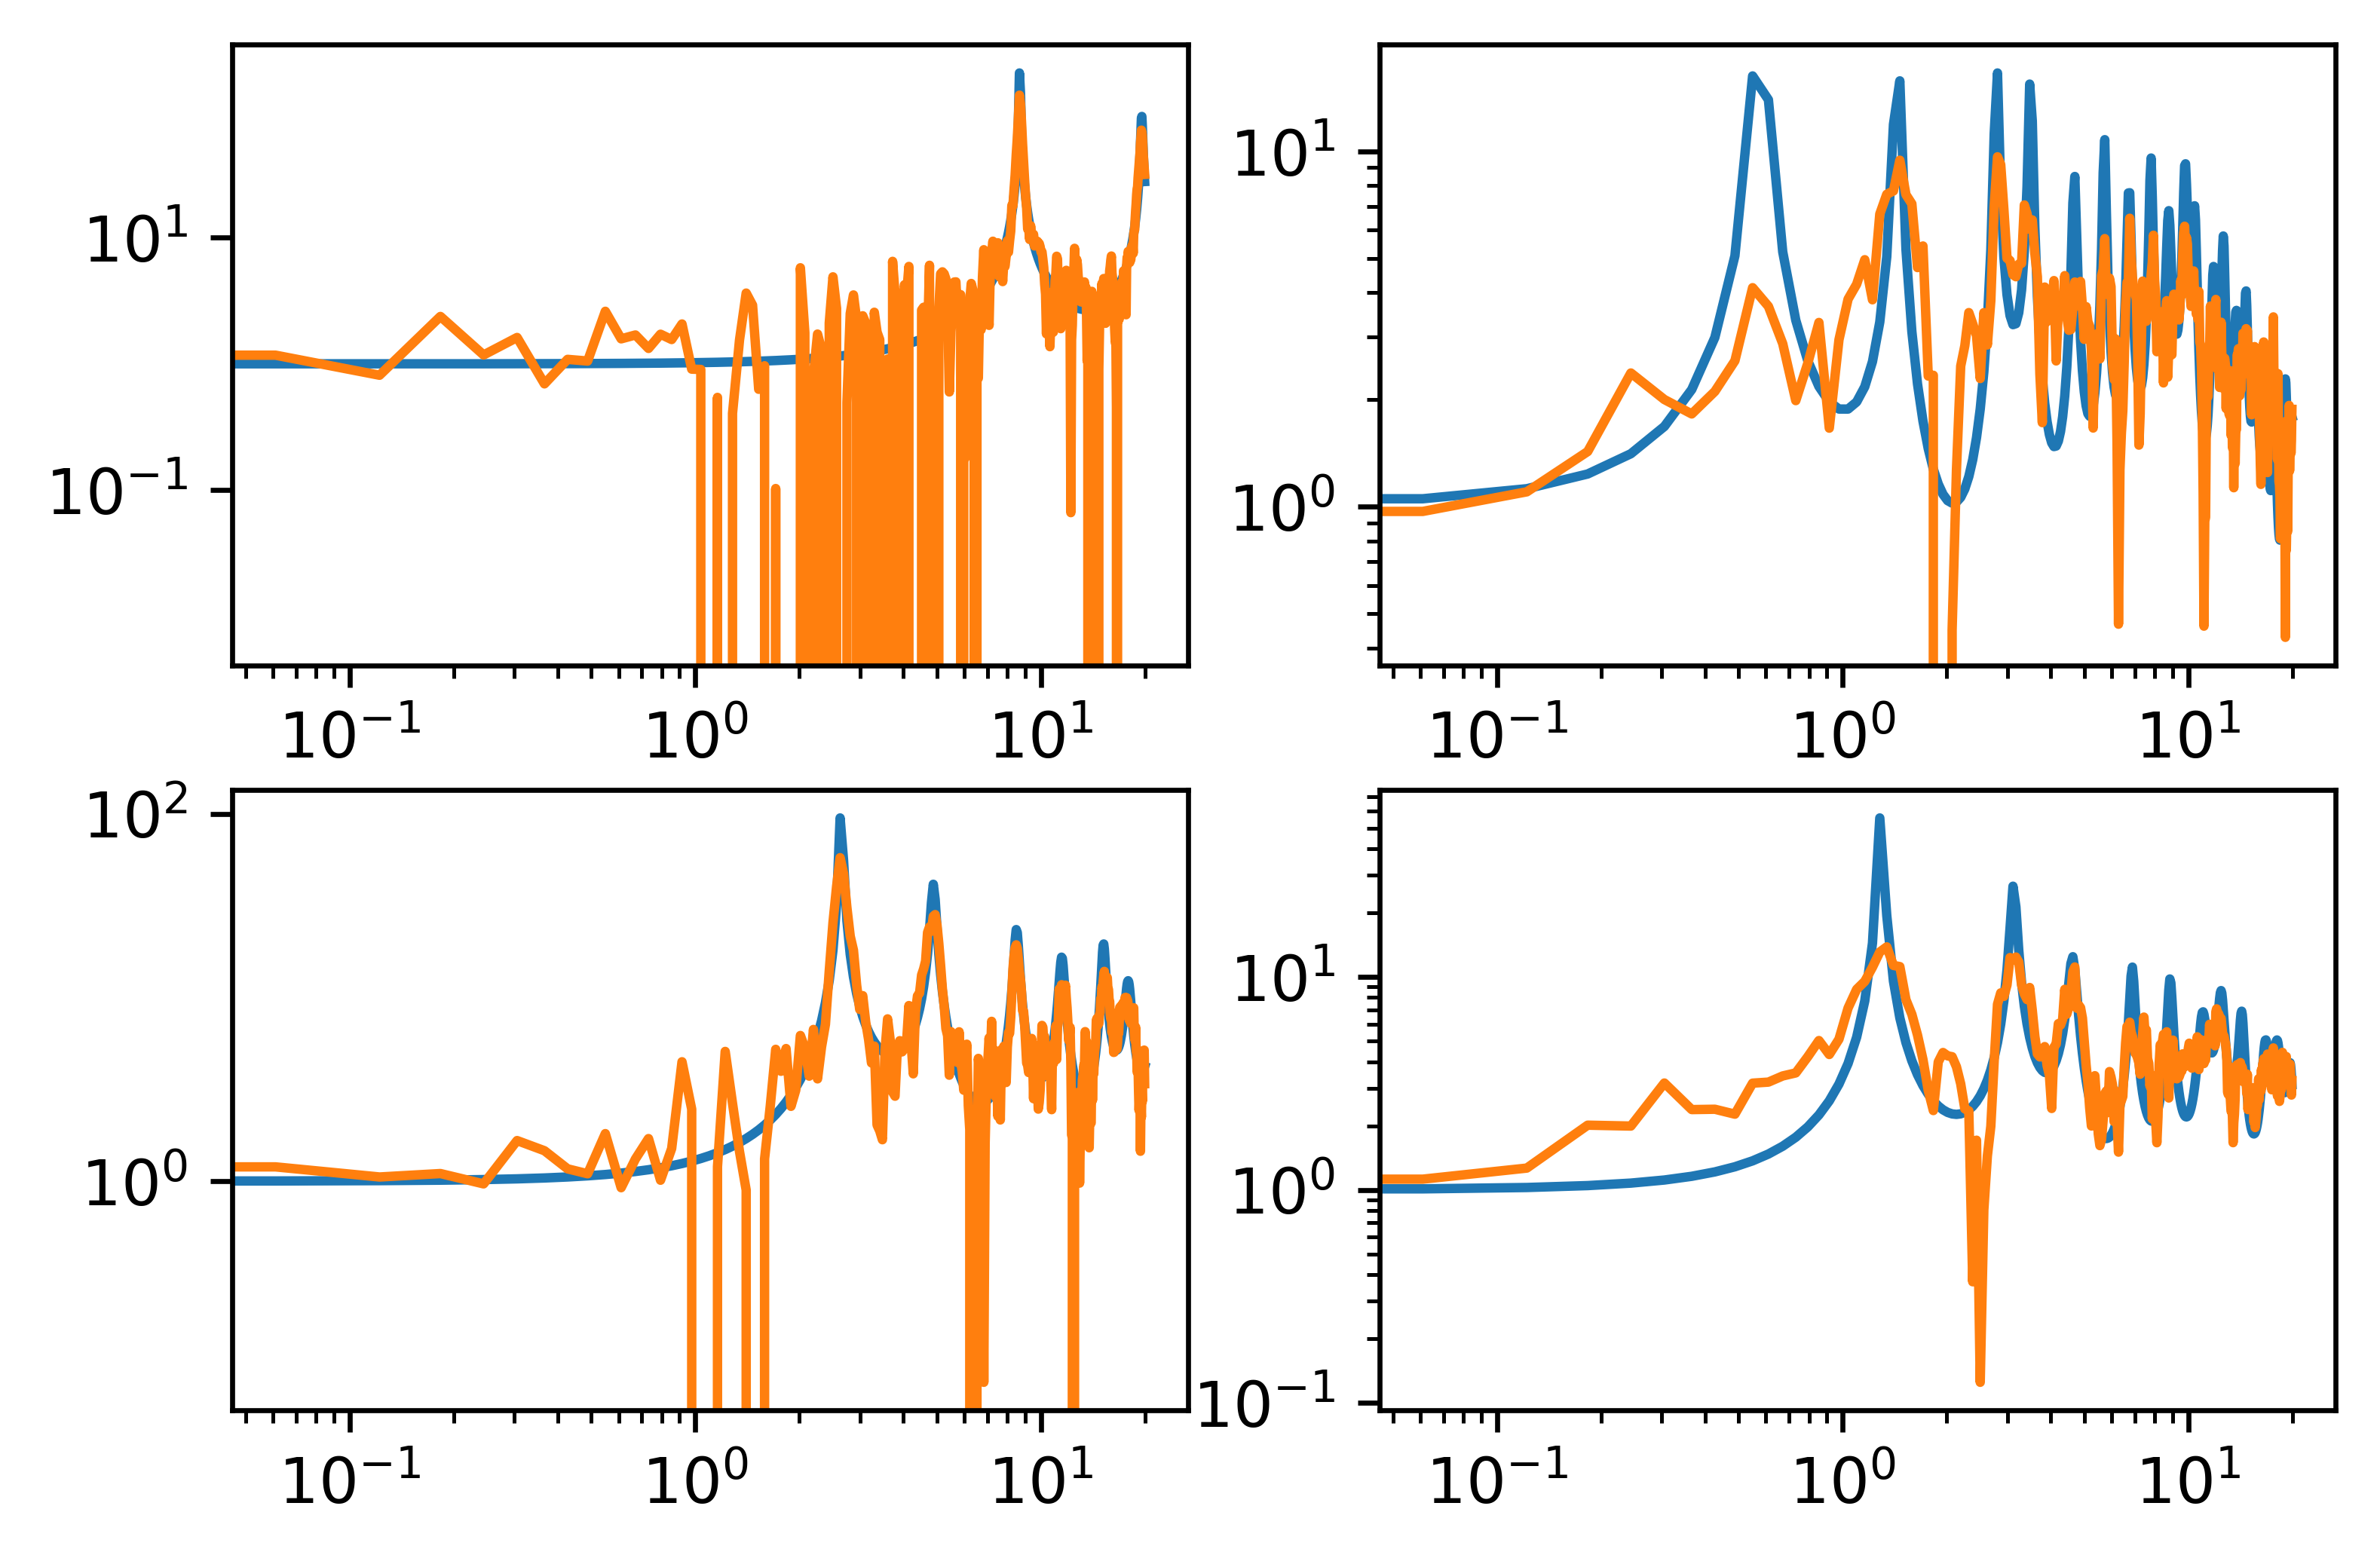

In [13]:
fig, ax = plt.subplots(2,2,dpi=600)
ax = ax.flatten()
for i in range(4):
    idx = np.random.randint(y_train.shape[0])
    ax[i].loglog(ttf.freq, y_train[idx, :len(ttf.freq)])
    ax[i].loglog(ttf.freq, train[idx, :len(ttf.freq)])

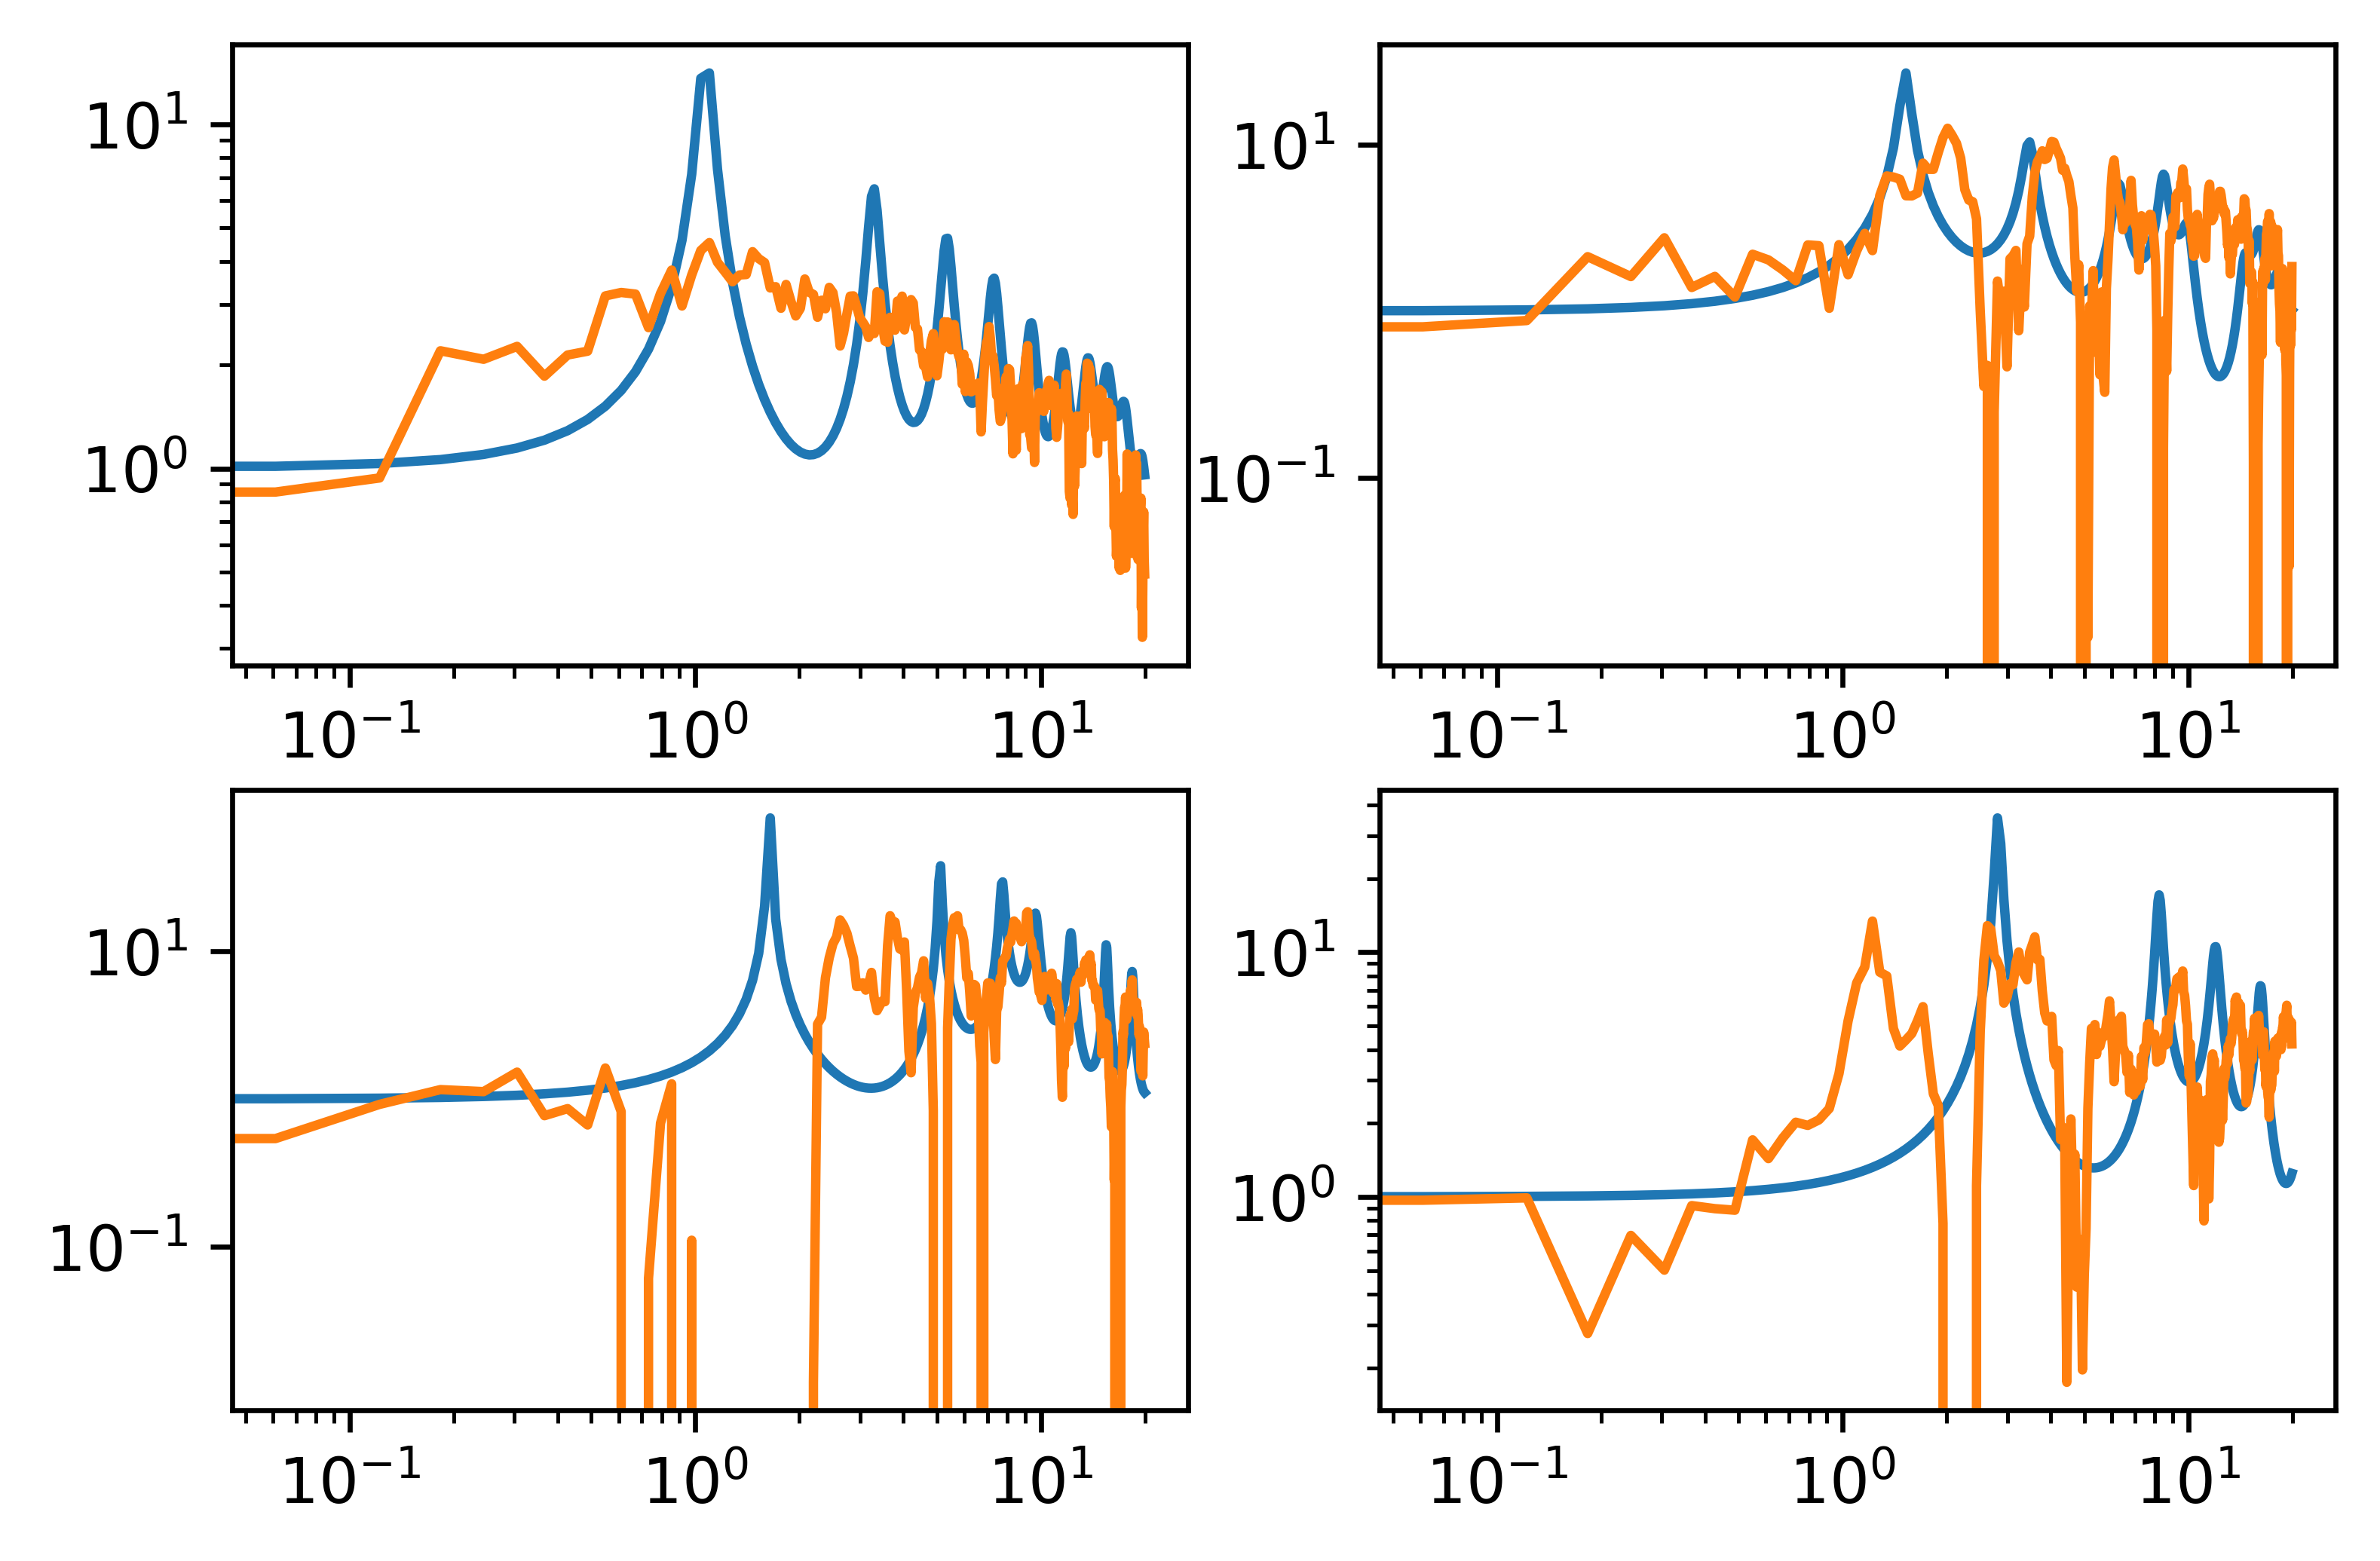

In [14]:
fig, ax = plt.subplots(2,2,dpi=600)
ax = ax.flatten()
for i in range(4):
    idx = np.random.randint(y_test.shape[0])
    ax[i].loglog(ttf.freq, y_test[idx, :len(ttf.freq)])
    ax[i].loglog(ttf.freq, predict[idx, :len(ttf.freq)])

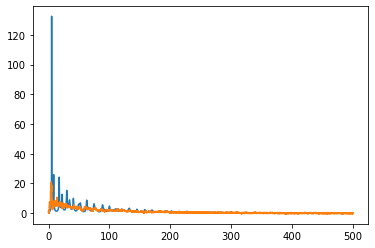

In [36]:
plt.plot(ttf.freq, y_test[0, :len(ttf.freq)])
plt.plot(ttf.freq, predict[0, :len(ttf.freq)])

In [133]:

linear_layer_2d = nn.Linear(in_features=64, out_features=32)
# 1st dimension (128) = batch dimension, input 64 x 64
input_2d = torch.randn(128, 64, 64)
output_2d = linear_layer_2d(input_2d)
print(output_2d.size())
# torch.Size([128, 64, 32])

# 1d input (2d flattened)
linear_layer_1d = nn.Linear(in_features=4096, out_features=32)
# input_1d size = [128, 4096]
input_1d = torch.flatten(input_2d, start_dim=1)
print(input_1d.size())
output_1d = linear_layer_1d(input_1d)
print(output_1d.size())

torch.Size([128, 64, 32])
torch.Size([128, 4096])
torch.Size([128, 32])


In [134]:
linear_layer_1d = nn.Linear(in_features=500, out_features=32)
output_1d = linear_layer_1d(torch.from_numpy(x_data.astype('float32')))
print(output_1d.size())

torch.Size([643, 32])
